In [1]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.keras.applications.ResNet50V2(
          include_top=False, weights=None, input_shape=(128,128,3), pooling="avg"
      ).summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5
CROP_TO = 32
SEED = 26



PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005


In [4]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
ssl_ds = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds = (
    ssl_ds.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)



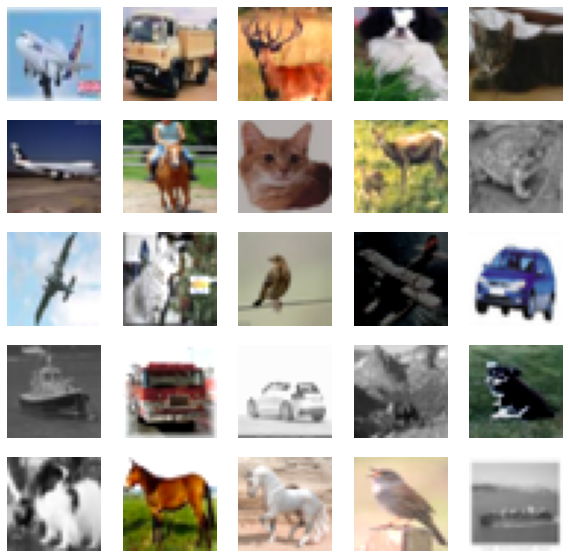

In [6]:




# We then zip both of these datasets.
ssl_ds_zip = tf.data.Dataset.zip((ssl_ds, ssl_ds))



# Ensure that the different versions of the dataset actually contain
# identical images.
sample_image = next(iter(ssl_ds_zip))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_image[n%2][n//2,:,:,:].numpy().astype("int"))
    plt.axis("off")
plt.show()



# definition projection head : 

## first way : use sequential layer

exemple : vgg like network

In [7]:


def build_vgg_block(n_conv_layer,depth,pooling_type):
    list_layer=[]
    for i in range(n_conv_layer):
        list_layer.append(layers.Conv2D(depth,3, activation='relu',padding="same"))
    
    if pooling_type=="MaxPooling2D":
        list_layer.append(layers.MaxPooling2D(pool_size=(2, 2),padding="valid"))
    else:
        raise NotImplementedError("pooling "+pooling_type+" is not implemented") 
    return list_layer
    
    
def get_vgg_backbone(input_shape,hparams):
    """
    hparams : dict with keys block1 .... blockn
    
    """
    list_layer=[layers.Input(input_shape)]
    for i in range(1,len(hparams)+1):
        list_layer=list_layer+build_vgg_block(**hparams[f"block{i}"])
        
        
    return tf.keras.Sequential(list_layer)


hparams_vgg={"block1":
             {"n_conv_layer":3,
             "depth":64,
             "pooling_type":"MaxPooling2D"},
            
            "block2":
             {"n_conv_layer":3,
             "depth":128,
             "pooling_type":"MaxPooling2D"},
             
             "block3":
             {"n_conv_layer":3,
             "depth":256,
             "pooling_type":"MaxPooling2D"}
            
            }
    
vgg_backbone=get_vgg_backbone((32,32,3),hparams_vgg)




vgg_backbone.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       147584    
                                                        

## second way : use the functional API

exemple with resnet like network

I didn't use batch normalisation & the output isn't normalize

In [8]:

def apply_resnet_block(x,downsample,conv_by_block):
    
    depth_input=x.shape[-1]
    
    
    if downsample:
        depth=depth_input*2
        skiped=layers.Conv2D(depth,1,strides=(2,2),activation=None)(x)#linear projection
        x=layers.Conv2D(depth,3,strides=(2,2), activation='relu',padding="same")(x)
    else:
        depth=depth_input
        skiped=x
        x=layers.Conv2D(depth,3, activation='relu',padding="same")(x)
        
    for i in range(1,conv_by_block):
        x=layers.Conv2D(depth,3, activation='relu',padding="same")(x)
        
    x=skiped+x
   
    return x

def get_resnet_backbone(input_shape,hparams):
    """
    """
    inputs=layers.Input((32,32,3))
    x=layers.Conv2D(hparams["depth_first_convolution"],7,strides=(2,2),activation='relu',padding="same")(inputs)
    
    for i in range(1,hparams["number_of_block"]+1):
        x=apply_resnet_block(x,i in hparams["downsample_num"],hparams["conv_by_block"])
       
        

    #x=layers.MaxPooling2D(pool_size=(2, 2),padding="valid")(x)
        
    return tf.keras.Model(inputs,x)



hparams_resnet={"depth_first_convolution":64,
                "number_of_block":33,
                "downsample_num":[4,8,14],
                "conv_by_block":2
            }


In [9]:
def select_backbone(backbone):
    if backbone=="vgg9":
        backbone_model={"block1":
             {"n_conv_layer":3,
             "depth":64,
             "pooling_type":"MaxPooling2D"},
            
            "block2":
             {"n_conv_layer":3,
             "depth":128,
             "pooling_type":"MaxPooling2D"},
             
             "block3":
             {"n_conv_layer":3,
             "depth":256,
             "pooling_type":"MaxPooling2D"}}
        
        
    elif backbone=="resnet":
        hparams_resnet={"depth_first_convolution":64,
                "number_of_block":33,
                "downsample_num":[4,8,14],
                "conv_by_block":2
            }


        resnet=get_resnet_backbone((32,32,3),hparams_resnet)
                        
                        
                        

### third way : overide the keras.model definition
implementation of the SimSiam model

# define the training procedure

- wich optimizer will be used
- how will the loss be computed (in the standard case, we compute the loss relative to the output of the model & the correct
- what function do we use for the loss

In [10]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder(backbone=None):
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    
    
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    if backbone:
        x=backbone(x)
    else:
        x = resnet_cifar10_v2.stem(x)
        x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")




def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


## using compile & custum loss 

expect to compute the loss of the ouput of the neural network relative to the label of the datas. <br />
In order to implement this, we need to make a fake labels with the same length than the original dataset <br />

because the model includes l1 loss from the projection head, the loss is not between 0&1


In [11]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        

    
    def call(self, inputs):
        
        ds_one, ds_two = inputs[0],inputs[1]
        z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
        p1, p2 = self.predictor(z1), self.predictor(z2)

        return tf.transpose(tf.stack([z1,p1,z2,p2]),perm=[1,0,2])
        
data=next(iter(ssl_ds_zip))
simsiam=SimSiam(get_encoder(),get_predictor())
pred=simsiam((tf.zeros((2,32,32,3)),tf.zeros((2,32,32,3))))#dummy variable to build the computation graph

simsiam.summary()

Model: "sim_siam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 2048)              5303344   
                                                                 
 predictor (Sequential)      (None, 2048)              2101248   
                                                                 
Total params: 7,404,592
Trainable params: 7,392,368
Non-trainable params: 12,224
_________________________________________________________________


In [12]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))



def loss_simsiam(y_true, y_pred):
    """
    custum loss for sim_siam
    y_true : (): fake prediction
    y_pred : (z1,p1,z2,p2)
   
    
    (we have to keep the signature according to https://keras.io/api/losses/#creating-custom-losses)
    
    """
    loss=compute_loss(y_pred[:,1], y_pred[:,2])/2 + compute_loss(y_pred[:,3], y_pred[:,0])/ 2
    
    return loss
    
    

In [13]:
fake_labels=tf.data.Dataset.from_tensor_slices([0.]*len(x_train)).batch(BATCH_SIZE).prefetch(AUTO)
fake_ssl_with_label=tf.data.Dataset.zip((ssl_ds_zip,fake_labels))



num_training_samples = len(x_train)

steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)

simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6),loss=loss_simsiam)
simsiam.fit(fake_ssl_with_label,epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/5
 76/391 [====>.........................] - ETA: 1:02 - loss: 3.1712

KeyboardInterrupt: 

## custumize the train_step in keras model : like in the originial notebook

I add the call methode in order to be able to build the model & call the .summary method <br />
I added the loss correspounding to the L1 losses

In [16]:

    
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    def call(self, inputs):
        
        ds_one, ds_two = inputs[0],inputs[1]
        z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
        p1, p2 = self.predictor(z1), self.predictor(z2)
        return z1,p1,z2,p2

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2
         

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    
data=next(iter(ssl_ds_zip))
simsiam=SimSiam(get_encoder(),get_predictor())
pred=simsiam((tf.zeros((1,32,32,3)),tf.zeros((1,32,32,3))))#dummy variable to build the computation graph

simsiam.summary()

Model: "sim_siam_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 2048)              5303344   
                                                                 
 predictor (Sequential)      (None, 2048)              2101248   
                                                                 
Total params: 7,404,594
Trainable params: 7,392,368
Non-trainable params: 12,226
_________________________________________________________________


Epoch 1/5
391/391 [==============================] - 88s 208ms/step - loss: -0.8991
Epoch 2/5
391/391 [==============================] - 80s 204ms/step - loss: -0.9197
Epoch 3/5
391/391 [==============================] - 80s 206ms/step - loss: -0.9232
Epoch 4/5
391/391 [==============================] - 80s 204ms/step - loss: -0.9247
Epoch 5/5
391/391 [==============================] - 81s 206ms/step - loss: -0.9251


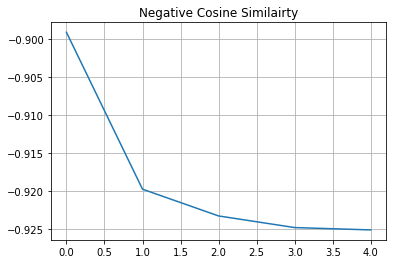

In [17]:
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds_zip, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

## adding the loss from the regularization of the projection head



In [18]:

    
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_similarity_tracker = tf.keras.metrics.Mean(name="loss_similarity")
        self.loss_regularization_tracker = tf.keras.metrics.Mean(name="loss_regularization")
    def call(self, inputs):
        
        ds_one, ds_two = inputs[0],inputs[1]
        z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
        p1, p2 = self.predictor(z1), self.predictor(z2)
        return z1,p1,z2,p2

    @property
    def metrics(self):#in order to apply reset_state() automaticly
        return [self.loss_similarity_tracker,self.loss_regularization_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss_similarity = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2
            loss_regularization=sum(self.losses)
            loss=loss_similarity+loss_regularization

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_similarity_tracker.update_state(loss_similarity)
        self.loss_regularization_tracker.update_state(loss_regularization)
        return {"loss_sim": self.loss_similarity_tracker.result(),"loss_regu": self.loss_regularization_tracker.result()}
    
    
data=next(iter(ssl_ds_zip))
simsiam=SimSiam(get_encoder(),get_predictor())
pred=simsiam((tf.zeros((1,32,32,3)),tf.zeros((1,32,32,3))))#dummy variable to build the computation graph

simsiam.summary()

Model: "sim_siam_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 2048)              5303344   
                                                                 
 predictor (Sequential)      (None, 2048)              2101248   
                                                                 
Total params: 7,404,596
Trainable params: 7,392,368
Non-trainable params: 12,228
_________________________________________________________________


Epoch 1/5
391/391 [==============================] - 95s 209ms/step - loss_sim: -0.8109 - loss_regu: 3.1422
Epoch 2/5
391/391 [==============================] - 87s 221ms/step - loss_sim: -0.8892 - loss_regu: 2.9744
Epoch 3/5
391/391 [==============================] - 82s 210ms/step - loss_sim: -0.9044 - loss_regu: 2.8510
Epoch 4/5
391/391 [==============================] - 82s 210ms/step - loss_sim: -0.9119 - loss_regu: 2.7810
Epoch 5/5
391/391 [==============================] - 86s 221ms/step - loss_sim: -0.9147 - loss_regu: 2.7559


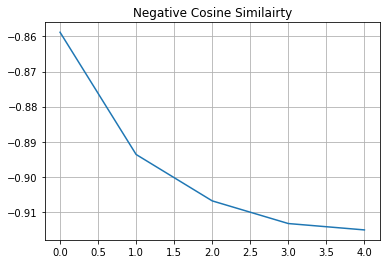

In [19]:
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss_sim", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds_zip, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss_sim"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

## add relu to the predictor

In [20]:

def get_predictor_v2():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
            layers.ReLU(),
        ],
        name="predictor",
    )
    return model


In [21]:

    
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_similarity_tracker = tf.keras.metrics.Mean(name="loss_similarity")
        self.loss_regularization_tracker = tf.keras.metrics.Mean(name="loss_regularization")
    def call(self, inputs):
        
        ds_one, ds_two = inputs[0],inputs[1]
        z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
        p1, p2 = self.predictor(z1), self.predictor(z2)
        return z1,p1,z2,p2

    @property
    def metrics(self):#in order to apply reset_state() automaticly
        return [self.loss_similarity_tracker,self.loss_regularization_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss_similarity = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2
            loss_regularization=sum(self.losses)
            loss=loss_similarity+loss_regularization

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_similarity_tracker.update_state(loss_similarity)
        self.loss_regularization_tracker.update_state(loss_regularization)
        return {"loss_sim": self.loss_similarity_tracker.result(),"loss_regu": self.loss_regularization_tracker.result()}
    
    
data=next(iter(ssl_ds_zip))
simsiam=SimSiam(get_encoder(),get_predictor_v2())
pred=simsiam((tf.zeros((1,32,32,3)),tf.zeros((1,32,32,3))))#dummy variable to build the computation graph

simsiam.summary()

Model: "sim_siam_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 2048)              5303344   
                                                                 
 predictor (Sequential)      (None, 2048)              2101248   
                                                                 
Total params: 7,404,596
Trainable params: 7,392,368
Non-trainable params: 12,228
_________________________________________________________________


In [22]:
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss_sim", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds_zip, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss_sim"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

Epoch 1/5
391/391 [==============================] - 94s 211ms/step - loss_sim: -0.8618 - loss_regu: 3.1417
Epoch 2/5
241/391 [=================>............] - ETA: 31s - loss_sim: -0.9206 - loss_regu: 2.9878

KeyboardInterrupt: 

## redifine the training loop

to do : try if it actually works


In [ ]:

num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))

loss_similarity_tracker = tf.keras.metrics.Mean(name="loss_similarity")
loss_regularization_tracker = tf.keras.metrics.Mean(name="loss_regularization")

for epoch in range(EPOCHS):
    for batch in ssl_ds_zip:
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = simsiam.encoder(ds_one), simsiam.encoder(ds_two)
            p1, p2 = simsiam.predictor(z1), simsiam.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss_similarity = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2
            loss_regularization=sum(simsiam.losses)
            loss=loss_similarity+loss_regularization

        # Compute gradients and update the parameters.
        learnable_params = (
            simsiam.encoder.trainable_variables + simsiam.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        loss_similarity_tracker.update_state(loss_similarity)
        loss_regularization_tracker.update_state(loss_regularization)
    print("loss sim : ",loss_similarity_tracker.result(),"loss regu : ",loss_regularization_tracker)
        
        
    loss_similarity_tracker.reset_states()
    loss_regularization_tracker.reset_states()